Original Shape: (303, 15)
Cleaned Shape: (303, 14)
Age          0
Sex          0
ChestPain    0
RestBP       0
Chol         0
Fbs          0
RestECG      0
MaxHR        0
ExAng        0
Oldpeak      0
Slope        0
Ca           0
Thal         0
AHD          0
dtype: int64
Target value counts:
AHD
0    164
1    139
Name: count, dtype: int64


/tmp/ipython-input-1312550612.py:53: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["AHD"] = df["AHD"].replace({"Yes": 1, "No": 0})


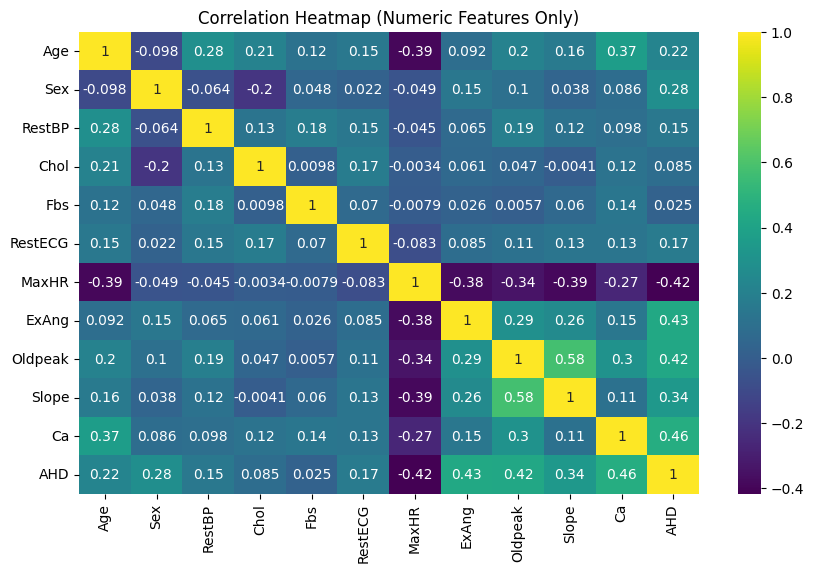

Numeric Columns: ['Age', 'Sex', 'RestBP', 'Chol', 'Fbs', 'RestECG', 'MaxHR', 'ExAng', 'Oldpeak', 'Slope', 'Ca']
Categorical Columns: ['ChestPain', 'Thal']

=== Random Forest Results ===
Accuracy: 0.8688524590163934
ROC AUC: 0.8733766233766233
[[27  6]
 [ 2 26]]

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.82      0.87        33
           1       0.81      0.93      0.87        28

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.88      0.87      0.87        61


Best Parameters: {'clf__max_depth': None, 'clf__n_estimators': 400}
Best CV Score: 0.8179421768707483

=== Optimized Random Forest ===
Accuracy: 0.8852459016393442
ROC AUC: 0.8912337662337663
[[27  6]
 [ 1 27]]

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.82      0.89        33
           1       0.82      0.96      0

In [ ]:
# ===============================
# HEART DISEASE – FULL IMPROVED ML PIPELINE
# ===============================

# Step 1: Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb


# ===============================
# Step 2: Load Dataset
# ===============================

df = pd.read_csv("/content/Heart.csv")
print("Original Shape:", df.shape)
df.head()


# ===============================
# Step 3: Clean Dataset
# ===============================

# Drop useless indexing column
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

# Fill missing numeric values with median
df["Ca"] = df["Ca"].fillna(df["Ca"].median())

# Fill missing categorical values with mode
df["Thal"] = df["Thal"].fillna(df["Thal"].mode()[0])

print("Cleaned Shape:", df.shape)
print(df.isnull().sum())


# ===============================
# Step 4: Convert Target Column
# ===============================

# Convert AHD into binary 1/0
df["AHD"] = df["AHD"].replace({"Yes": 1, "No": 0})

print("Target value counts:")
print(df["AHD"].value_counts())


# ===============================
# Step 5: EDA – Correlation Heatmap
# ===============================

num_df = df.select_dtypes(include=[np.number])

plt.figure(figsize=(10, 6))
sns.heatmap(num_df.corr(), annot=True, cmap="viridis")
plt.title("Correlation Heatmap (Numeric Features Only)")
plt.show()


# ===============================
# Step 6: Feature Split
# ===============================

X = df.drop("AHD", axis=1)
y = df["AHD"]

numeric_cols = X.select_dtypes(include=[np.number]).columns
categorical_cols = X.select_dtypes(exclude=[np.number]).columns

print("Numeric Columns:", list(numeric_cols))
print("Categorical Columns:", list(categorical_cols))


# ===============================
# Step 7: Preprocessing Pipeline
# ===============================

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ]
)


# ===============================
# Step 8: Train-Test Split
# ===============================

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


# ===============================
# Step 9: Random Forest Model
# ===============================

rf_pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", RandomForestClassifier(n_estimators=200, random_state=42))
])

rf_pipeline.fit(X_train, y_train)
rf_pred = rf_pipeline.predict(X_test)

print("\n=== Random Forest Results ===")
print("Accuracy:", accuracy_score(y_test, rf_pred))
print("ROC AUC:", roc_auc_score(y_test, rf_pred))
print(confusion_matrix(y_test, rf_pred))
print("\nClassification Report:\n", classification_report(y_test, rf_pred))


# ===============================
# Step 10: Hyperparameter Tuning (RandomForest)
# ===============================

param_grid = {
    "clf__n_estimators": [100, 200, 400],
    "clf__max_depth": [None, 5, 10, 20],
}

grid = GridSearchCV(rf_pipeline, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid.fit(X_train, y_train)

print("\nBest Parameters:", grid.best_params_)
print("Best CV Score:", grid.best_score_)

best_model = grid.best_estimator_
best_pred = best_model.predict(X_test)

print("\n=== Optimized Random Forest ===")
print("Accuracy:", accuracy_score(y_test, best_pred))
print("ROC AUC:", roc_auc_score(y_test, best_pred))
print(confusion_matrix(y_test, best_pred))
print("\nClassification Report:\n", classification_report(y_test, best_pred))


# ===============================
# Step 11: XGBoost Classifier
# ===============================

xgb_pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("xgb", xgb.XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.9,
        colsample_bytree=0.9,
        eval_metric="logloss"
    ))
])

xgb_pipeline.fit(X_train, y_train)
xgb_pred = xgb_pipeline.predict(X_test)

print("\n=== XGBoost Results ===")
print("Accuracy:", accuracy_score(y_test, xgb_pred))
print("ROC AUC:", roc_auc_score(y_test, xgb_pred))
print(confusion_matrix(y_test, xgb_pred))
print("\nClassification Report:\n", classification_report(y_test, xgb_pred))


# ===============================
# Step 12: Sample Prediction
# ===============================

sample = X_test.iloc[0:1]
print("\nSample Prediction:")
print("Predicted:", xgb_pipeline.predict(sample)[0])
